## 데이터 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.options.display.float_format = '{:.5f}'.format

In [39]:
file_path = '../data/'

df = pd.read_csv(file_path + 'processed_data.csv')

In [40]:
train_data = df[df['_type'] == 'train'].drop(columns=['_type', 'year_month_date'])
test_data = df[df['_type'] == 'test'].drop(columns=['_type', 'year_month_date'])
sample_submission = pd.read_csv(file_path + 'sample_submission.csv')

## 변수별 분포 파악

### 기본 정보 확인

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1801228 entries, 0 to 1801227
Data columns (total 19 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   index                           int64  
 1   area_m2                         float64
 2   contract_year_month             int64  
 3   contract_day                    int64  
 4   contract_type                   int64  
 5   floor                           int64  
 6   built_year                      int64  
 7   latitude                        float64
 8   longitude                       float64
 9   age                             int64  
 10  deposit                         float64
 11  nearest_subway_distance_km      float64
 12  interest_rate                   float64
 13  prev_month_interest_rate        float64
 14  nearest_elementary_distance_km  float64
 15  nearest_middle_distance_km      float64
 16  nearest_high_distance_km        float64
 17  nearest_park_distance_km        

In [26]:
train_data.describe()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,nearest_subway_distance_km,interest_rate,prev_month_interest_rate,nearest_elementary_distance_km,nearest_middle_distance_km,nearest_high_distance_km,nearest_park_distance_km,nearest_park_area
count,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000
mean,900613.50000,75.18833,202133.12602,15.89943,1.20380,10.05197,2004.19877,37.47721,126.96623,17.06597,38162.22942,1.42535,2.15760,2.12205,0.33447,0.53054,0.68884,0.26273,15767.18707
std,519969.87967,25.52632,135.28146,8.62600,0.88528,6.97336,11.15132,0.16251,0.17012,11.12796,26103.77420,2.09935,1.19130,1.17363,0.19499,0.36966,0.50422,0.28889,63099.98194
min,0.00000,10.32150,201904.00000,1.00000,0.00000,-4.00000,1961.00000,36.91791,126.47871,-3.00000,300.00000,0.02793,0.80000,0.80000,0.02052,0.01578,0.02096,0.00000,0.00000
25%,450306.75000,59.75000,202008.00000,9.00000,0.00000,5.00000,1995.00000,37.37976,126.84216,7.00000,21000.00000,0.43673,1.06000,1.06000,0.20578,0.29118,0.36039,0.13032,1500.10000
50%,900613.50000,77.15000,202111.00000,16.00000,2.00000,9.00000,2004.00000,37.50227,126.99759,17.00000,32000.00000,0.72629,1.69000,1.69000,0.29735,0.45738,0.57809,0.19966,2409.00000
75%,1350920.25000,84.96000,202212.00000,23.00000,2.00000,14.00000,2015.00000,37.58205,127.08881,26.00000,47800.00000,1.43739,3.56000,3.53000,0.40917,0.66601,0.87784,0.30689,8929.00000
max,1801227.00000,317.36000,202312.00000,31.00000,2.00000,68.00000,2024.00000,38.18194,127.66090,62.00000,1100000.00000,26.28670,4.34000,4.34000,3.39939,5.83878,8.56636,7.82052,1764901.70000


### 분포 확인

`area_m2`, `floor`, `deposit`, `nearest_subway_distance_km`, `nearest_elementary_distance_km`,  
`nearest_middle_distance_km`, `nearest_high_distance_km`, `nearest_park_distance_km`, `nearest_park_area`의 분포는 비대칭이므로 변환 필요

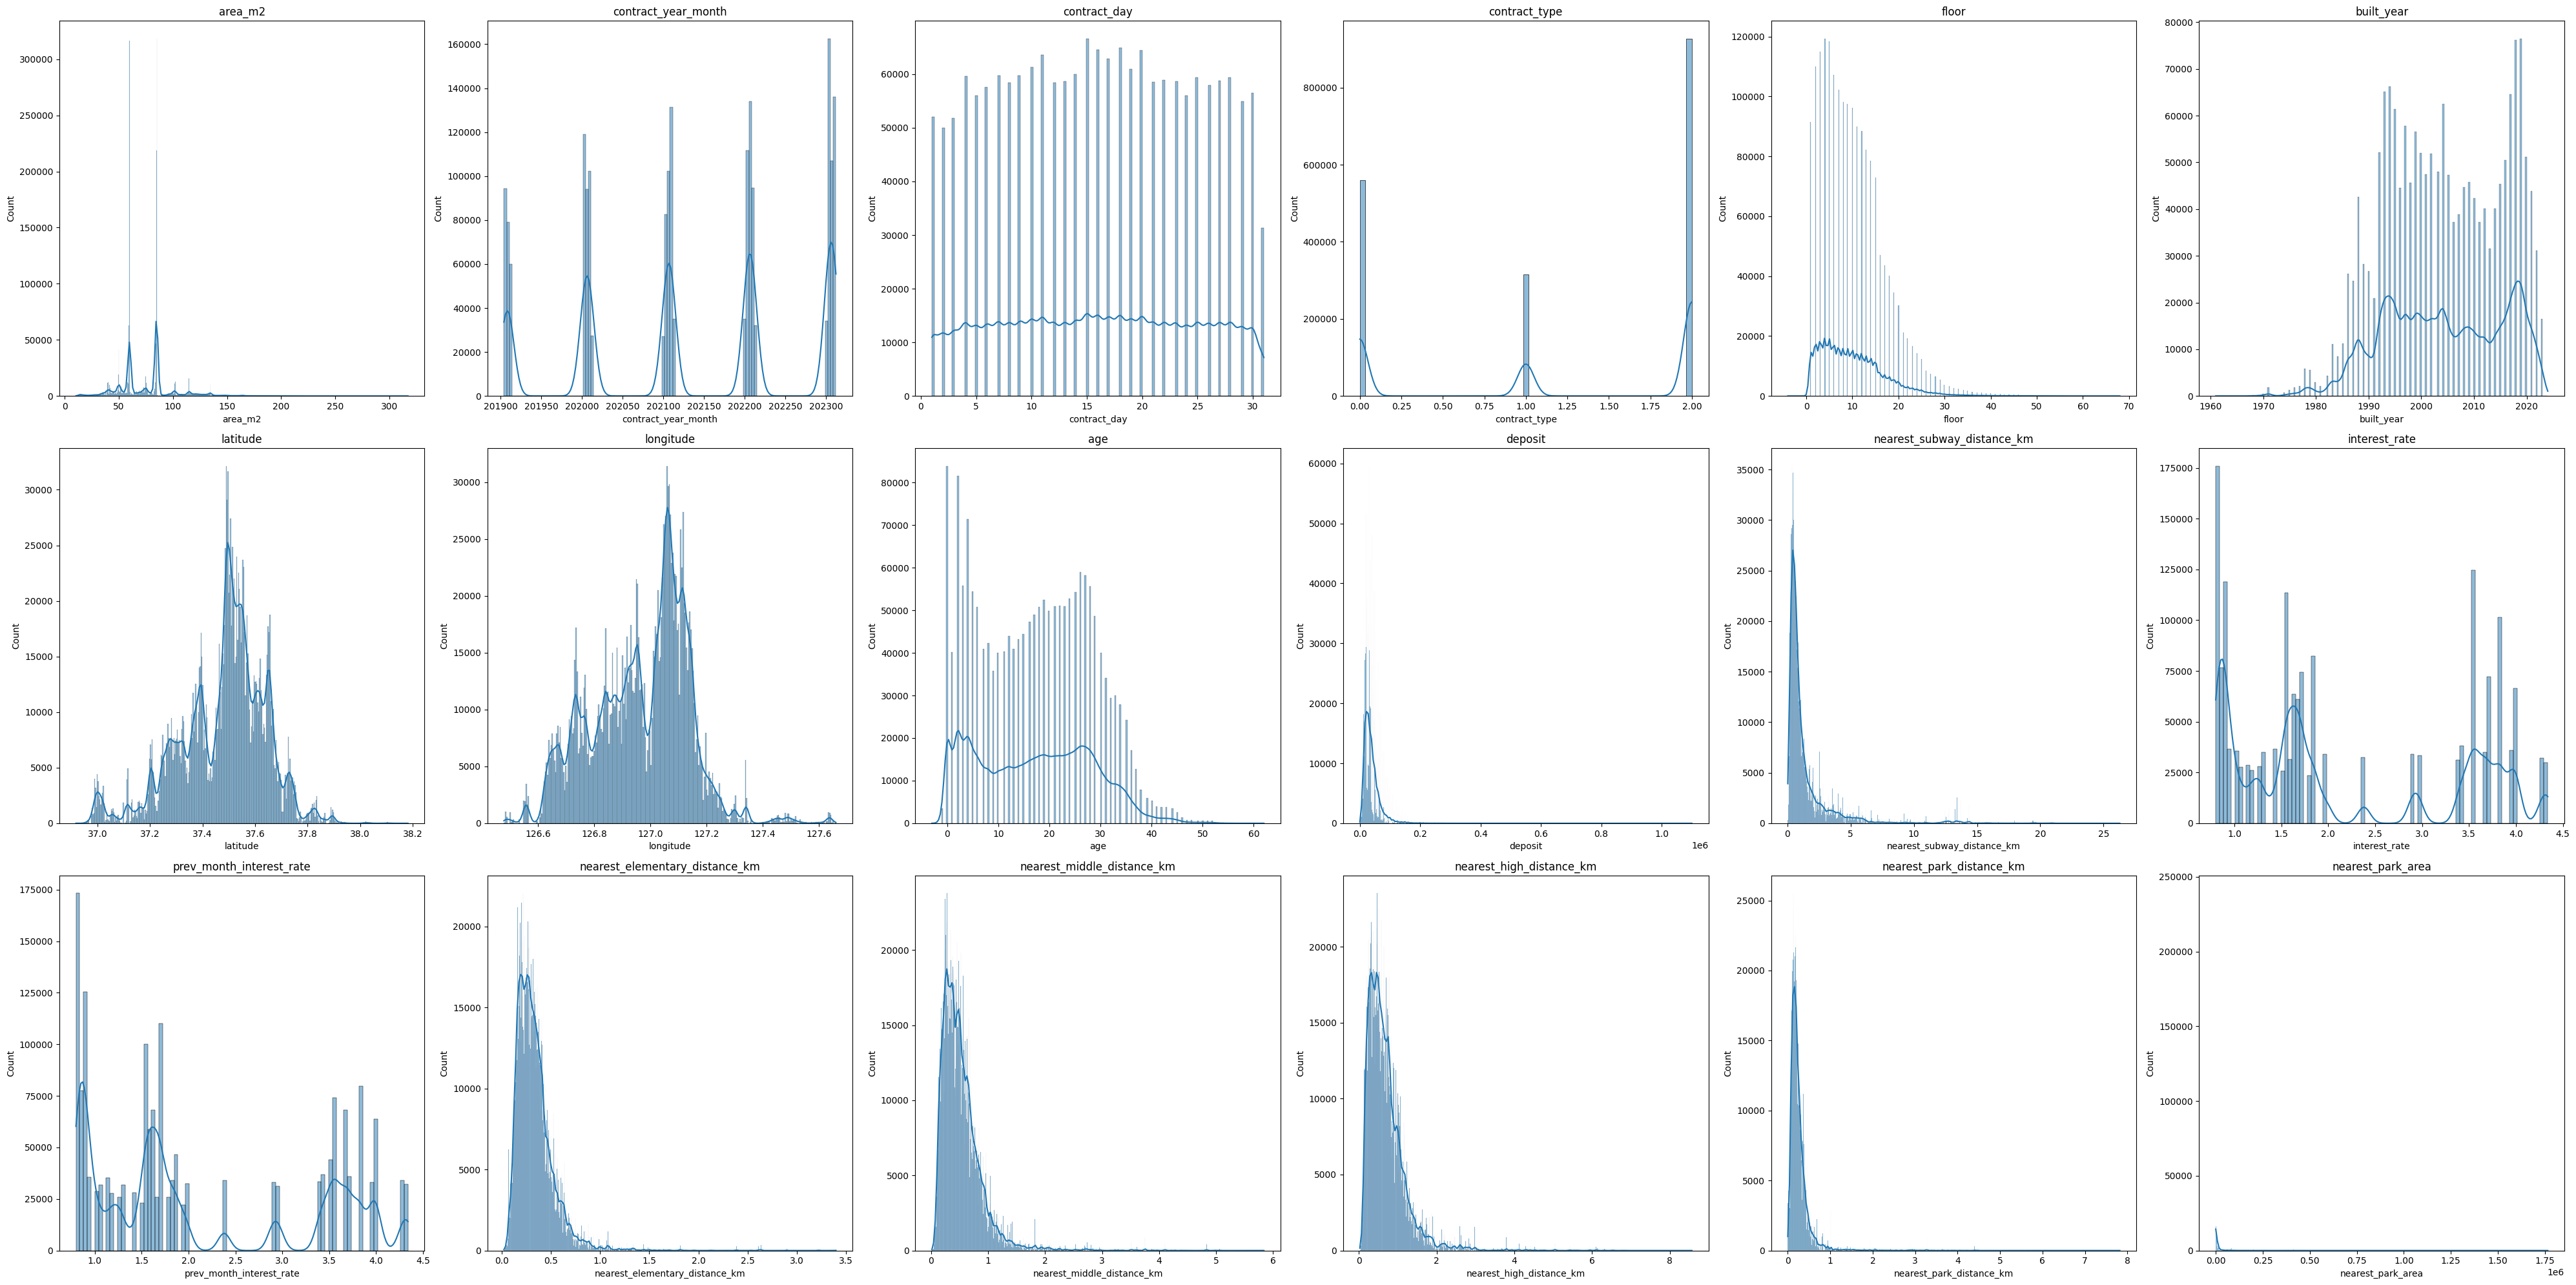

In [29]:
columns = train_data.select_dtypes(include=['float64', 'int64']).columns
columns = columns[columns!='index']

fig, axes = plt.subplots(3, 6, figsize=(40, 20))

for i, column in enumerate(columns):
    row = i // 6
    col = i % 6
    sns.histplot(train_data[column], kde=True, ax=axes[row, col])
    axes[row, col].set_title(column)

plt.tight_layout()
plt.show()

##### - 계약 유형 (0: 신규, 1: 갱신, 2: 모름)

`2: 모름`에 대한 경우가 많음  
레이블 인코딩이라 순서가 반영되지 않을까 의문 → 이진 벡터로 변환?  

In [9]:
train_data['contract_type'].value_counts().sort_index()

contract_type
0    559687
1    314755
2    926786
Name: count, dtype: int64

### 이상치 확인

`area_m2`, `floor`, `deposit`, `nearest_subway_distance_km`, `nearest_elementary_distance_km`,  
`nearest_middle_distance_km`, `nearest_high_distance_km`, `nearest_park_distance_km`, `nearest_park_area`는 이상치가 많이 있으므로 변환 필요

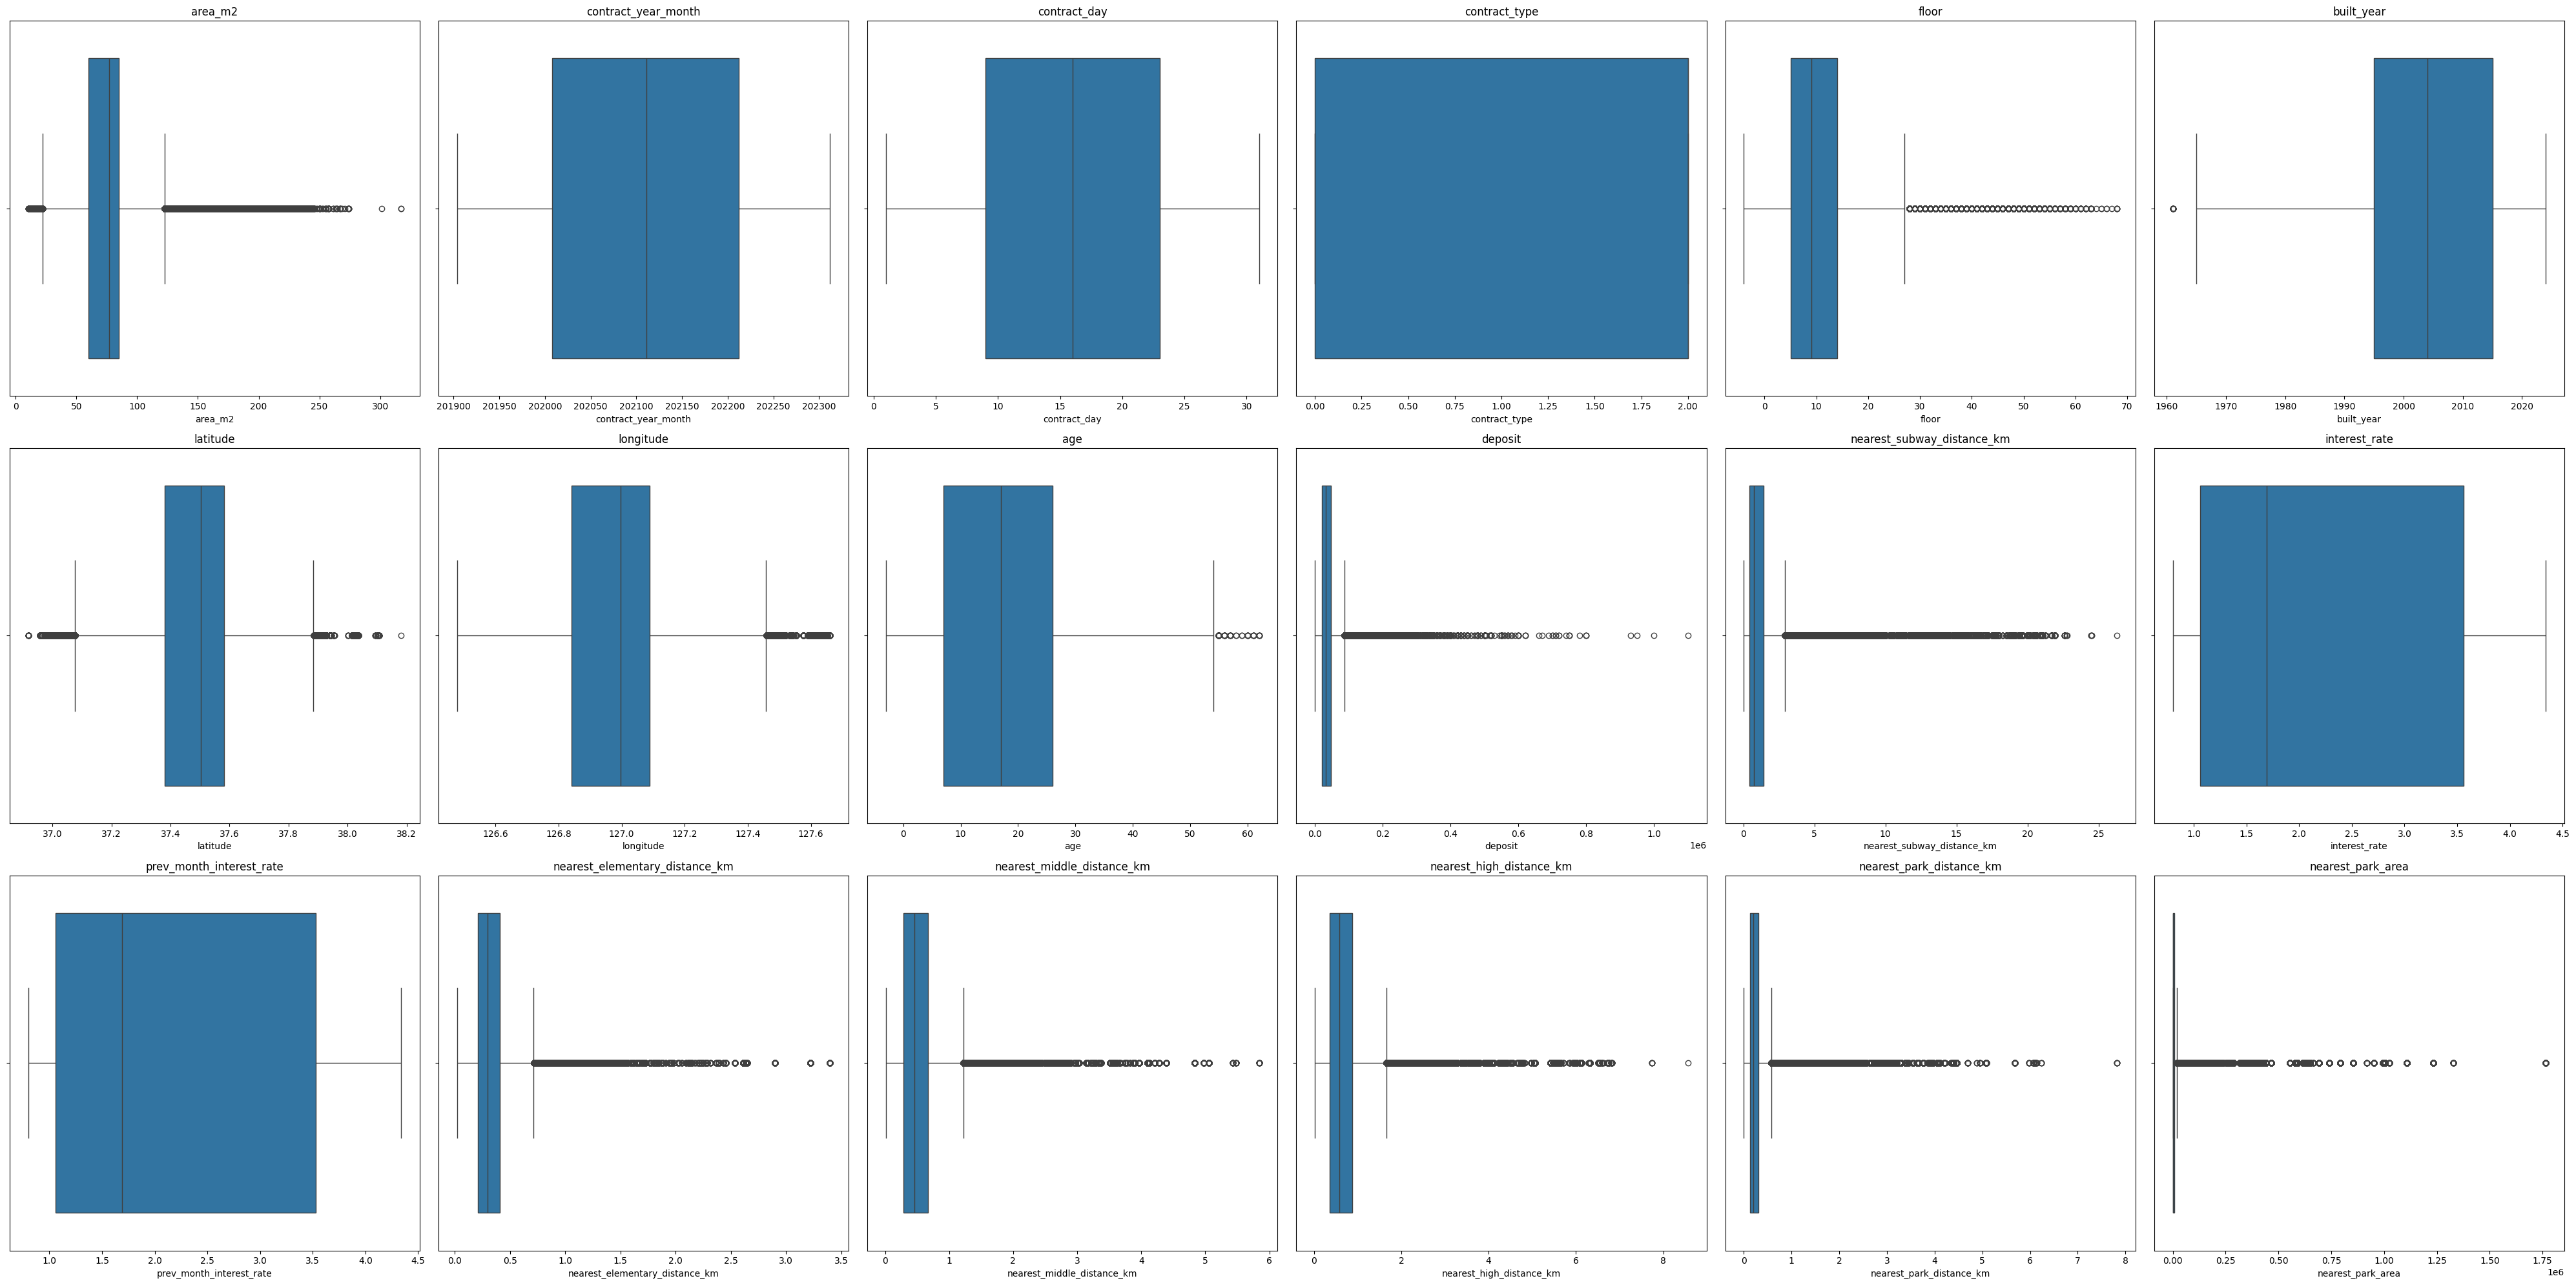

In [6]:
columns = train_data.select_dtypes(include=['float64', 'int64']).columns
columns = columns[columns!='index']

fig, axes = plt.subplots(3, 6, figsize=(40, 20))

for i, column in enumerate(columns):
    row = i // 6
    col = i % 6
    sns.boxplot(x=train_data[column], ax=axes[row, col])
    axes[row, col].set_title(column)

plt.tight_layout()
plt.show()

### 결측치 확인

모든 컬럼에 대한 결측치가 없으므로 처리할 필요 x

In [12]:
train_data.isna().sum()

index                             0
area_m2                           0
contract_year_month               0
contract_day                      0
contract_type                     0
floor                             0
built_year                        0
latitude                          0
longitude                         0
age                               0
deposit                           0
nearest_subway_distance_km        0
interest_rate                     0
prev_month_interest_rate          0
nearest_elementary_distance_km    0
nearest_middle_distance_km        0
nearest_high_distance_km          0
nearest_park_distance_km          0
nearest_park_area                 0
dtype: int64

## 변수 간 상호작용 파악

In [17]:
deposit = train_data.pop('deposit')
train_data['deposit'] = deposit

### 상관관계 히트맵

| 변수                                      | 상관관계      |
|-------------------------------------------|--------------|
| **`deposit`과 `area_m2`**                   | **매우 높은 양의 상관관계** |
| `contract_year_month`과 `contract_type`  | 높은 음의 상관관계(왜지?)  |
| `contract_year_month`과 `interest_rate`  | 높은 양의 상관관계  |
| `contract_year_month`과 `prev_month_interest_rate` | 높은 양의 상관관계  |
| `contract_type`과 `interest_rate`         | 높은 음의 상관관계  |
| `contract_type`과 `prev_month_interest_rate`  | 높은 음의 상관관계  |
| `floor`과 `built_year`                    | 양의 상관관계    |
| `floor`과 `age`                           | 음의 상관관계    |
| **`built_year`과 `age`**                     | **매우 높은 음의 상관관계** |
| `built_year`과 `nearest_subway_distance_km` | 높은 양의 상관관계  |
| `built_year`과 `elementary`               | 높은 양의 상관관계  |
| `built_year`과 `middle`                   | 높은 양의 상관관계  |
| `built_year`과 `high`                     | 높은 양의 상관관계  |
| **`interest_rate`과 `prev_month_interest_rate`** | **매우 높은 양의 상관관계** |    

왜 `deposit`과 `interest_rate`의 상관관계가 높지 않지?


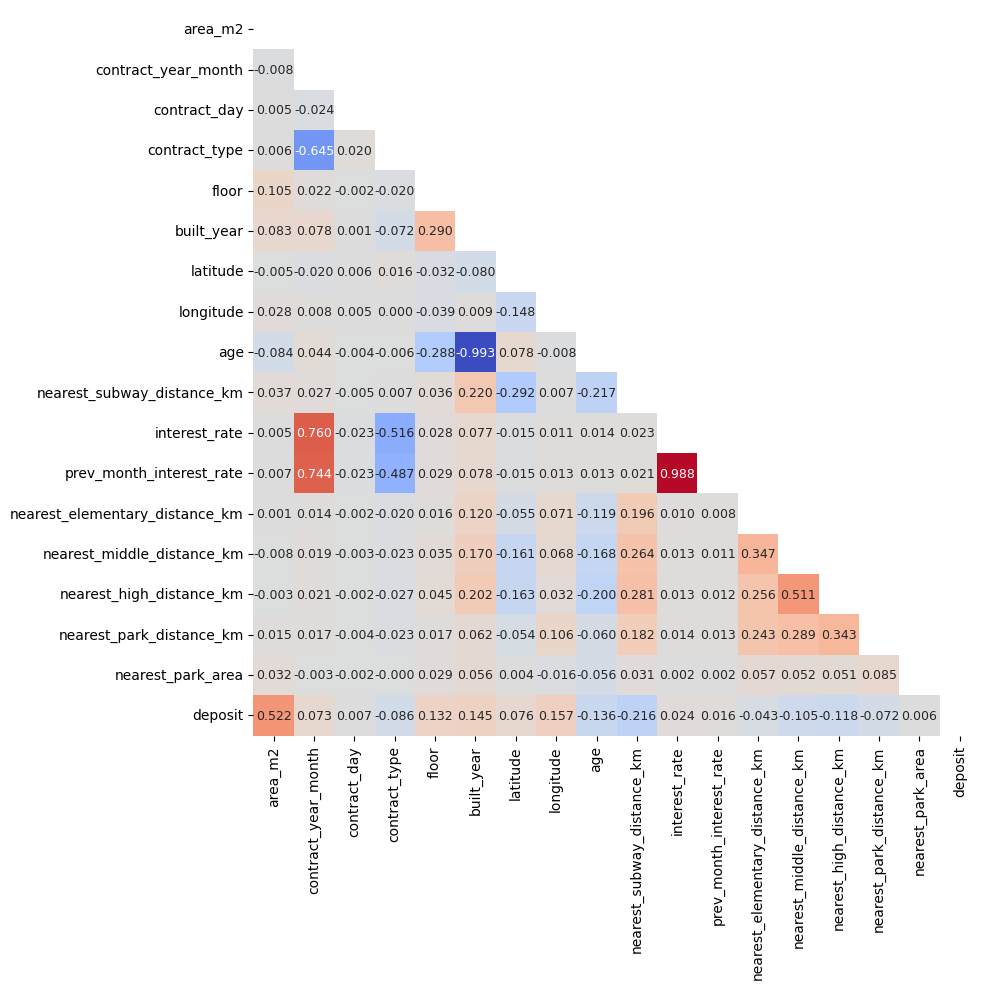

In [28]:
train_corr = train_data.drop(columns='index').corr()
mask = np.triu(np.ones_like(train_corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(train_corr, mask=mask, annot=True, fmt='.3f', cmap='coolwarm',
            square=True, cbar=False, vmin=-1, vmax=1, annot_kws={"size": 9})

plt.tight_layout()
plt.show()

In [29]:
# 상관계수 임계값
corr_threshold = 0.13

# deposit 변수와 모든 변수 간의 상관계수
deposit_corr = train_corr[['deposit']].drop('deposit').reset_index()
deposit_corr.columns = ['column', 'corr']

# 절댓값이 corr_threshold 이상인 변수들 필터링
high_corr = deposit_corr[np.abs(deposit_corr['corr']) >= corr_threshold]
print(high_corr)

                       column     corr
0                     area_m2  0.52162
4                       floor  0.13234
5                  built_year  0.14496
7                   longitude  0.15737
8                         age -0.13648
9  nearest_subway_distance_km -0.21632


## 베이스라인 코드

### 기본 데이터

In [30]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

columns_needed = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'deposit']
columns_needed_test = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude']
train_data = train_data[columns_needed]
test_data = test_data[columns_needed_test]

holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 1594362, number of used features: 7
[LightGBM] [Info] Start training from score 37814.733261
Holdout 데이터셋 성능
LightGBM MAE: 7904.04


#### 상관관계가 높은 변수 추가 사용

| 변수 조합                                  | MAE       |
|-------------------------------------------|-----------|
| `built_year`                                | 6523.63   |
| `age`                                       | 6549.25   |
| `nearest_subway_distance_km`               | 7771.65   |
| **`built_year`, `nearest_subway_distance_km`**   | **6423.91**   |
| `age`, `nearest_subway_distance_km`          | 6472.44   |
| `age`, `built_year`                           | 6484.38   |
| `age`, `built_year`, `nearest_subway_distance_km` | 6442.10   |


In [36]:
high_corr

,column,corr
0,area_m2,0.52162
4,floor,0.13234
5,built_year,0.14496
7,longitude,0.15737
8,age,-0.13648
9,nearest_subway_distance_km,-0.21632


In [72]:
train_data = df[df['_type'] == 'train'].drop(columns=['_type', 'year_month_date'])
test_data = df[df['_type'] == 'test'].drop(columns=['_type', 'year_month_date'])

columns_needed = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'built_year', 'nearest_subway_distance_km', 'deposit']
columns_needed_test = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'built_year', 'nearest_subway_distance_km']
train_data = train_data[columns_needed]
test_data = test_data[columns_needed_test]

holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1228
[LightGBM] [Info] Number of data points in the train set: 1594362, number of used features: 9
[LightGBM] [Info] Start training from score 37814.733261
Holdout 데이터셋 성능
LightGBM MAE: 6423.91


### processed 데이터 사용

In [50]:
train_data = df[df['_type'] == 'train'].drop(columns=['_type', 'year_month_date', 'age'])
test_data = df[df['_type'] == 'test'].drop(columns=['_type', 'year_month_date', 'age'])

holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2852
[LightGBM] [Info] Number of data points in the train set: 1594362, number of used features: 17
[LightGBM] [Info] Start training from score 37814.733261
Holdout 데이터셋 성능
LightGBM MAE: 6331.85


#### 변수 제거 고려

| 변수 제거 조합                                    | MAE         |
|-----------------------------------------------|------------|
| `age`                                        | 6331.85    |
| `built_year`                                 | 6357.71    |
| `prev_month_interest_rate`                   | 6321.47    |
| `nearest_middle_distance_km`                 | 6321.94    |
| `nearest_high_distance_km`                   | 6320.65    |
| `age`, `prev_month_interest_rate`            | 6316.09    |
| `age`, `nearest_middle_distance_km`          | 6299.65    |
| `age`, `nearest_high_distance_km`            | 6322.52    |
| **`age`, `prev_month_interest_rate`, `nearest_middle_distance_km`** | **6289.63**    |


In [69]:
train_data = df[df['_type'] == 'train'].drop(columns=['_type', 'year_month_date', 'age', 'prev_month_interest_rate', 'nearest_middle_distance_km'])
test_data = df[df['_type'] == 'test'].drop(columns=['_type', 'year_month_date', 'age', 'prev_month_interest_rate', 'nearest_middle_distance_km'])

holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1594362, number of used features: 15
[LightGBM] [Info] Start training from score 37814.733261
Holdout 데이터셋 성능
LightGBM MAE: 6289.63


### contract_type을 이진 벡터로 변환

6331.85 → 6350.75로 오히려 성능 저하

In [34]:
df_binary = pd.get_dummies(df['contract_type'], prefix='contract', drop_first=False)
df_ = df.drop('contract_type', axis=1)
df_ = pd.concat([df_, df_binary], axis=1)

train_data = df_[df_['_type'] == 'train'].drop(columns=['_type', 'year_month_date'])
test_data = df_[df_['_type'] == 'test'].drop(columns=['_type', 'year_month_date'])

holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 1594362, number of used features: 20
[LightGBM] [Info] Start training from score 37814.733261
Holdout 데이터셋 성능
LightGBM MAE: 6350.75


변수 제거 고려 시 6289.63로 성능 동일

In [70]:
df_binary = pd.get_dummies(df['contract_type'], prefix='contract', drop_first=False)
df_ = df.drop('contract_type', axis=1)
df_ = pd.concat([df_, df_binary], axis=1)

train_data = df[df['_type'] == 'train'].drop(columns=['_type', 'year_month_date', 'age', 'prev_month_interest_rate', 'nearest_middle_distance_km'])
test_data = df[df['_type'] == 'test'].drop(columns=['_type', 'year_month_date', 'age', 'prev_month_interest_rate', 'nearest_middle_distance_km'])

holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1594362, number of used features: 15
[LightGBM] [Info] Start training from score 37814.733261
Holdout 데이터셋 성능
LightGBM MAE: 6289.63
